In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
sns.set()

In [24]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from loader_util.preprocessing import ImageToArrayPreprocessor, AspectAwarePreprocessor
from loader_util.datasets import SimpleDatasetLoader
from loader_util.nn.conv import FCHeadNet
##
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense, \
    Conv2DTranspose, BatchNormalization, UpSampling2D, LeakyReLU, Dropout, \
    Reshape, Input, Embedding, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from keras.datasets import fashion_mnist
from imutils import paths

In [25]:
# plot a list of loaded faces
def plot_images(faces, n):
    f, ax = plt.subplots(n, n, figsize=(16,16)) #type: Figure, axes
    faces_iter = iter(faces)
    for row in range(n):
        for col in range(n):
            axis = ax[row][col] #type: axes
            axis.set_yticklabels([])
            axis.set_xticklabels([])
            axis.grid(False)
            axis.imshow(next(faces_iter), cmap='gray_r')
    plt.show()

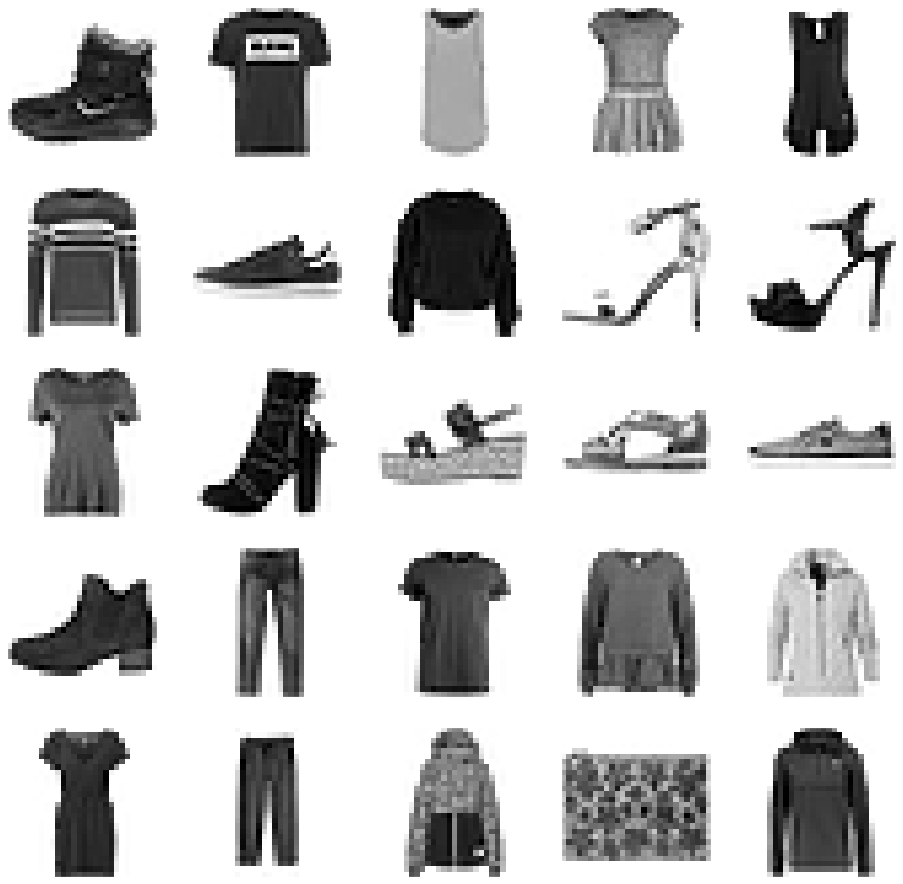

In [26]:
# load the data and plot
(trainx, trainy), (testx, testy) = fashion_mnist.load_data()
plot_images(trainx, 5)

In [27]:
# define the standalone discriminator
def define_discriminator(in_shape=(28,28,1), n_classes=10):

    # label input
    in_label = Input(shape=(1,))

    # embedding for categorical input
    li = Embedding(input_dim=n_classes, output_dim=50)(in_label)

    # scale upto image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)

    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 1))(li)

    # second branch image input
    in_image = Input(shape=in_shape)

    # concat label as channel
    merge = Concatenate()([in_image, li])

    # now downsample
    fe = Conv2D(filters=128,
                kernel_size=(3,3),
                strides=(2,2),
                padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)

    # downsample
    fe = Conv2D(filters=128,
                kernel_size=(3,3),
                strides=(2,2),
                padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)

    # flatten
    fe = Flatten()(fe)

    # dropout
    fe = Dropout(0.4)(fe)

    # output
    out_layer = Dense(units=1, activation='sigmoid')(fe)

    # define model
    model = Model([in_image, in_label], out_layer)

    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt,
                  metrics=['accuracy'])
    return model

In [28]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # label input
    in_label = Input(shape=(1,))

    # embedding for categorical input
    li = Embedding(input_dim=n_classes, output_dim=50)(in_label)

    # linear multiplication
    n_nodes = 7*7
    li = Dense(n_nodes)(li)

    # reshape to additional channel
    li = Reshape((7,7,1))(li)

    # image generator input-2
    in_lat = Input(shape=(latent_dim, ))

    # foundations for 7x7 image
    n_nodes = 128*7*7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape(target_shape=(7,7,128))(gen)

    # merge image gen and label input
    merge = Concatenate()([gen, li])

    # upsample to 14x14
    gen = Conv2DTranspose(filters=128,
                          kernel_size=(4,4),
                          strides=(2,2),
                          padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)

    # upsample to 28x28
    gen = Conv2DTranspose(filters=128,
                          kernel_size=(4,4),
                          strides=(2,2),
                          padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)

    #output
    out_layer = Conv2D(filters=1,
                       kernel_size=(7,7),
                       activation='tanh',
                       padding='same')(gen)

    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

In [ ]:
# define the combined GAN
def define_gan(g_model:Model, d_model:Model):
    # make weights in the discriminator not trainable
    d_model.trainable = False

    #get noise and label inputs frpm the generator model
    gen_noise, gen_label = g_model.input

    # get the image output from generator model
    gen_output = g_model.output

    print(f"gen_output:{gen_output.shape} gen_label:{gen_label.shape}")

    # connect image output and label input from generator as inputs to D
    gan_output = d_model([gen_output, gen_label])

    # define the GAN model
    model = Model([gen_noise, gen_label], gan_output)

    # compile the model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)

    return model

In [48]:
# load fashion mnist real images
def load_real_samples():
    # load dataset
    (trainx, trainy), (testx, testy) = fashion_mnist.load_data()

    # expand dim to 3d to add channel
    x = np.expand_dims(trainx, axis=-1)

    # convert from ints to floats
    x = x.astype('float32')

    # scale from [0,255] to [-1,1]
    x = (x - 127.5) / 127.5

    return [x, trainy]

def generate_real_samples(dataset:np.ndarray, n_samples):
    # split into images and labels
    images, labels = dataset

    # choose random instances
    ix = np.random.randint(0, images.shape[0], n_samples)

    # select random images and labels
    x, labels = images[ix], labels[ix]

    # generate class labels
    y = np.ones((n_samples, 1))

    return [x, labels], y

In [ ]:
# generate points in the latent space as G input
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)

    # reshape into batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)

    # generate labels
    labels = np.random.randint(0, n_classes, n_samples)

    return [z_input, labels]

def generate_fake_samples(g_model:Model, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)

    # predixt outputs
    images = g_model.predict([z_input, labels_input])

    # create class labels
    y = np.zeros((n_samples, 1))

    return [images, labels_input], y

In [ ]:
def save_plot(examples, epoch, labels, n=10):
    # plot images
    f, ax = plt.subplots(n, n, figsize=(30,30)) #type: Figure, axes
    plt.axis('off')
    plt.grid('off')

    examples_iter = iter(examples)
    labels_iter = iter(labels)
    for row in range(n):
        for col in range(n):
            ax[row][col].imshow(next(examples_iter))
            ax[row][col].set_title(f"Label: {next(labels_iter)}")

    # save plot to file
    filename = f"gan_conditional/generated_plot_epoch{epoch+1}.png"
    plt.savefig(filename)
    plt.close()

def summarise_performance(epoch,
                          g_model:Model,
                          d_model:Model,
                          dataset:np.ndarray,
                          latent_dim,
                          n_samples=100):
    # get real samples
    [xreal, labels], yreal = generate_real_samples(dataset, n_samples)

    # evaluate discriminator on real samples
    loss_real, acc_real = d_model.evaluate([xreal, labels], yreal, verbose=0)

    # prepare fake samples
    [xfake, labelsRandom], yfake = \
        generate_fake_samples(g_model, latent_dim, n_samples)

    # eval discrimiantor on fake samples
    loss_fake, acc_fake = d_model.evaluate([xfake, labelsRandom], yfake, verbose=0)

    # summarise discrimiantor performance
    print(f"Epoch={epoch+1} Discriminator Accuracy  "
          f"Real={acc_real*100} and "
          f"Fake={acc_fake*100}")

    # save the plot
    save_plot(xfake, epoch, labels)

    # save the generaor model to file
    g_model.save(f"gan_conditional/generator_model_epoch{epoch+1}.hdf5")

In [ ]:
def train(g_model:Model,
          d_model:Model,
          gan_model:Model,
          dataset:np.ndarray,
          latent_dim: int,
          n_epochs=100,
          n_batch=128):

    # evaluate batch per epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)

    # calculate half-batch
    half_batch = int(n_batch / 2)

    # manually enumerate epochs
    for i in range(n_epochs):

        # enumerate bacthes over the trainign set
        for j in range(bat_per_epo):

            # get randomly selected real samples
            [xreal, classLabelsReal], yreal = \
                generate_real_samples(dataset, half_batch)

            # get fake examples
            [xfake, randomClassLabelsFake], yfake = \
                generate_fake_samples(g_model, latent_dim,half_batch)

            # update the discrinator on real images
            d_loss1, d_acc1 = d_model.train_on_batch([xreal, classLabelsReal],
                                                     yreal)

            # update discriminator model weights
            d_loss2, d_acc2 = d_model.train_on_batch([xfake, randomClassLabelsFake],
                                                     yfake)

            # prepare points in the latent space as inputs for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim,
                                                            n_batch)

            # create inverted labels for the fake samples
            ygan = np.ones((n_batch, 1))

            # update the generator via the discriminators error
            g_loss = gan_model.train_on_batch([z_input, labels_input], ygan)

            # summarise the loss in this batch
            print(f"Train Epoch: {i+1}, {j+1}/{bat_per_epo} d1={d_loss1}, "
                  f"d2={d_loss2} g={g_loss}")

        if (i+1) % 5 == 0:
            summarise_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()
train(g_model, d_model, gan_model, dataset, latent_dim)